In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
        
    return concat_df

In [6]:
target_house = '오피스텔'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:00, 45.44it/s]


(179234, 11)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0


In [7]:
def land_shape2(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if '사다리' in x:
            return '사다리형'
        elif '장방' in x:
            return '장방형'
        elif '정방' in x:
            return '정방형'
        elif '부정' in x:
            return '부정형'
        elif '않음' in x:
            return '지정되지않음'
        elif '자루' in x:
            return '자루형'
        elif '삼각' in x:
            return '삼각형'
        else:
            return '기타'

In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
land_specs_df['지형형상2'] = land_specs_df['지형형상'].apply(land_shape2)
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 12)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가,지형형상2
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0,부정형
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0,부정형
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0,부정형
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0,부정형
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0,부정형


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 10)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,부정형
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지,부정형
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지,부정형
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지,부정형


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(176989, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '서초구'
target_dong = '서초동'
#target_purpose = '준공업'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(75, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
163873,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,22.67,22500,13,2016.0,4.0,2020-02-29,992.501103,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동
163874,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,20.72,22000,8,2016.0,4.0,2020-05-25,1061.776062,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동
163875,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,22.67,21000,4,2016.0,4.0,2020-06-08,926.334363,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동
163876,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,20.72,20500,11,2016.0,4.0,2020-12-14,989.382239,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동
163877,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,18.11,18690,19,2016.0,4.0,2020-12-29,1032.026505,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동


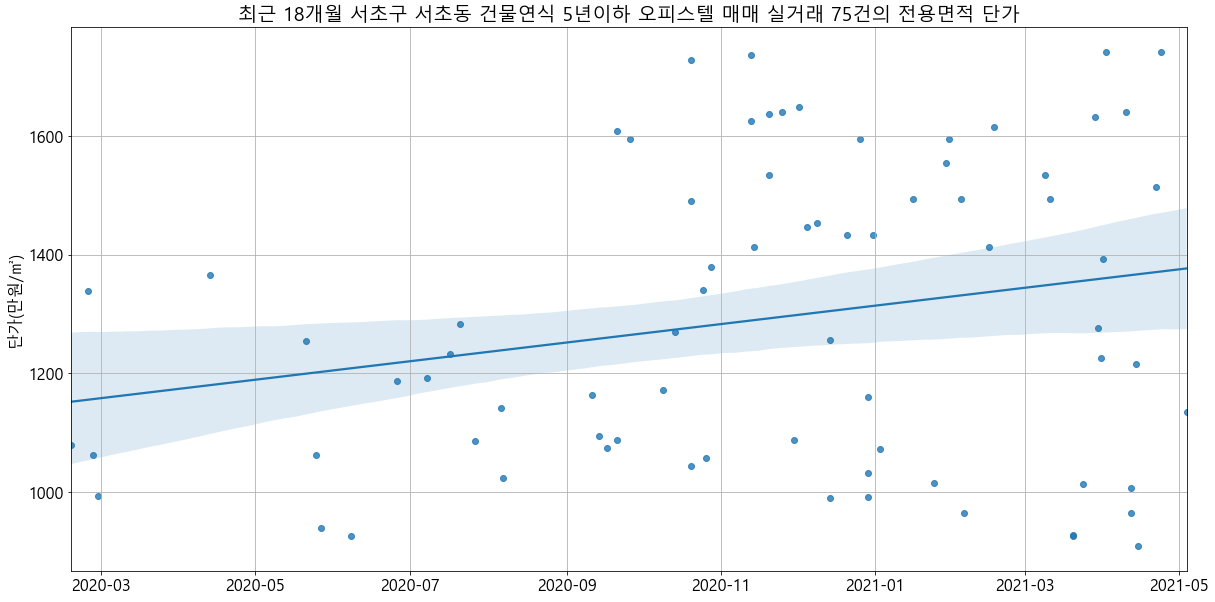

In [14]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_산포도.png'.format(target_gu, target_dong, target_house))

In [15]:
concat_df = pd.concat([target_df])

In [16]:
concat_df.head()

,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
163873,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,22.67,22500,13,2016.0,4.0,2020-02-29,992.501103,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동
163874,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,20.72,22000,8,2016.0,4.0,2020-05-25,1061.776062,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동
163875,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,22.67,21000,4,2016.0,4.0,2020-06-08,926.334363,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동
163876,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,20.72,20500,11,2016.0,4.0,2020-12-14,989.382239,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동
163877,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,18.11,18690,19,2016.0,4.0,2020-12-29,1032.026505,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동


In [17]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(75, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
0,서울특별시 서초구 서초동 1303-6,,현대썬앤빌 강남 더 인피닛,17.95,24500,12,2018.0,2.0,2020-04-13,1364.902507,3.0,대,495.3,일반상업지역,지정되지않음,업무용,평지,사다리형,중로각지,사다리형,서초구,서초동
1,서울특별시 서초구 서초동 1303-6,,현대썬앤빌 강남 더 인피닛,19.95,27500,13,2018.0,2.0,2020-10-28,1378.446115,3.0,대,495.3,일반상업지역,지정되지않음,업무용,평지,사다리형,중로각지,사다리형,서초구,서초동
2,서울특별시 서초구 서초동 1303-6,,현대썬앤빌 강남 더 인피닛,17.95,22900,15,2018.0,3.0,2021-03-30,1275.766017,3.0,대,495.3,일반상업지역,지정되지않음,업무용,평지,사다리형,중로각지,사다리형,서초구,서초동
3,서울특별시 서초구 서초동 1303-6,,현대썬앤빌 강남 더 인피닛,17.95,25000,13,2018.0,3.0,2021-04-01,1392.757660,3.0,대,495.3,일반상업지역,지정되지않음,업무용,평지,사다리형,중로각지,사다리형,서초구,서초동
4,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,22.67,22500,13,2016.0,4.0,2020-02-29,992.501103,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동


In [18]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(8, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
3,서울특별시 서초구 서초동 1303-6,,현대썬앤빌 강남 더 인피닛,17.95,25000,13,2018.0,3.0,2021-04-01,1392.757660,3.0,대,495.3,일반상업지역,지정되지않음,업무용,평지,사다리형,중로각지,사다리형,서초구,서초동
18,서울특별시 서초구 서초동 1337-2,효령로77길 34,아크로텔 강남역,22.67,20600,10,2016.0,5.0,2021-04-15,908.689899,5.0,대,1740.6,일반상업지역,지정되지않음,업무용,평지,가로장방,소로한면,장방형,서초구,서초동
25,서울특별시 서초구 서초동 1338-8,효령로79길 1,강남역파라디아골드,18.11,22000,9,2017.0,4.0,2021-04-14,1214.798454,4.0,대,568.3,일반상업지역,지정되지않음,업무용,평지,세로장방,소로각지,장방형,서초구,서초동
58,서울특별시 서초구 서초동 1582-3,반포대로18길 36,서초센트럴IPARK,54.55,95000,19,2020.0,1.0,2021-04-24,1741.521540,1.0,대,338.8,일반상업지역,제3종일반주거지역,상업기타,평지,사다리형,중로각지,사다리형,서초구,서초동
61,서울특별시 서초구 서초동 1588-5,효령로53길 24,디아레나 서초,39.55,40500,3,2020.0,0.0,2020-08-07,1024.020228,1.0,대,673.9,일반상업지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),장방형,서초구,서초동
62,서울특별시 서초구 서초동 1589-3,반포대로12길 23,서초아트갤러리,22.85,28000,8,2018.0,3.0,2021-03-31,1225.382932,3.0,대,328.9,일반상업지역,지정되지않음,상업기타,평지,정방형,세로각지(가),정방형,서초구,서초동
73,서울특별시 서초구 서초동 1601-10,서초중앙로5길 10-7,서초어반하이 오피스텔,18.51,21000,4,2018.0,3.0,2021-05-04,1134.521880,3.0,대,509.3,일반상업지역,지정되지않음,상업용,평지,부정형,소로각지,부정형,서초구,서초동
74,서울특별시 서초구 서초동 1601-6,효령로55길 16,스위트서초,36.74,34500,6,2018.0,2.0,2020-05-27,939.031029,3.0,대,334.9,일반상업지역,지정되지않음,상업기타,평지,사다리형,소로한면,사다리형,서초구,서초동


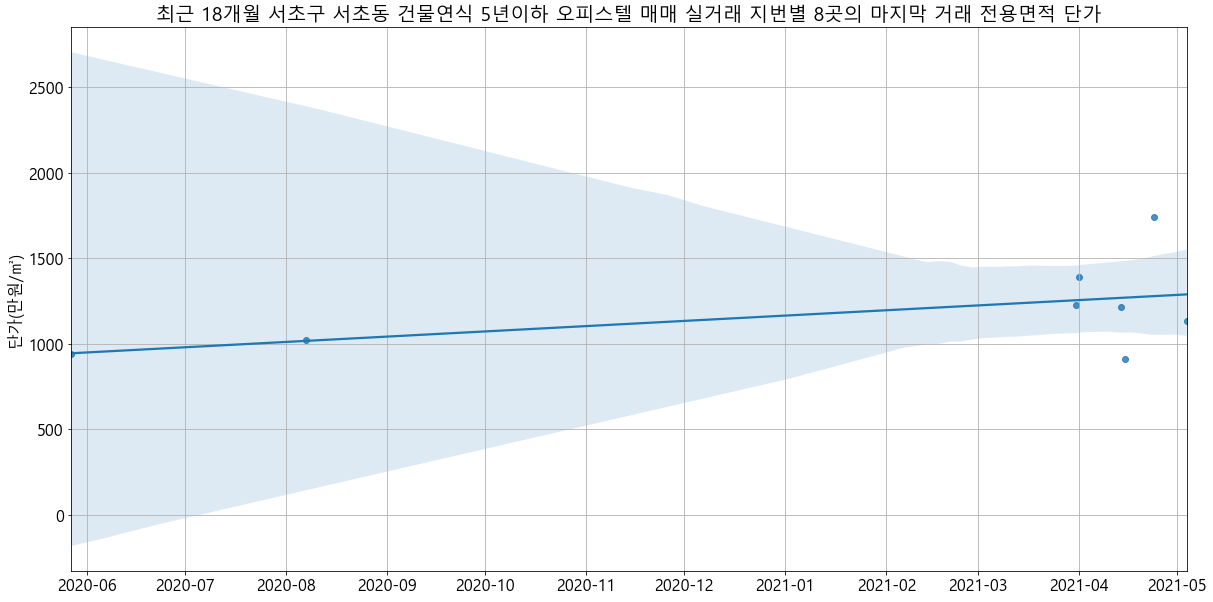

In [19]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(concat_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(concat_last_df['계약날짜']), y=concat_last_df['단가(만원/㎡)'])
#plt.ylim([500,2000])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_산포도.png'.format(target_gu, target_dong, target_house))

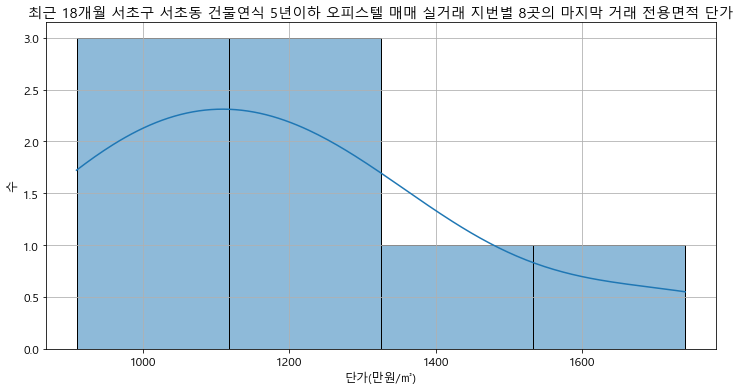

<Figure size 432x288 with 0 Axes>

In [20]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.grid(True)
plt.ylabel('수')
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
sns.histplot(concat_last_df['단가(만원/㎡)'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house))
plt.show()
plt.clf()

In [21]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [22]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '계약날짜', '단가(만원/㎡)', '용도지역명1', '도로접면']]
concat_last_df

,지번주소,건물(단지)명,건축년도,계약날짜,단가(만원/㎡),용도지역명1,도로접면
0,서울특별시 서초구 서초동 1303-6,현대썬앤빌 강남 더 인피닛,2018.0,2021-04-01,1392.757660,일반상업지역,중로각지
1,서울특별시 서초구 서초동 1337-2,아크로텔 강남역,2016.0,2021-04-15,908.689899,일반상업지역,소로한면
2,서울특별시 서초구 서초동 1338-8,강남역파라디아골드,2017.0,2021-04-14,1214.798454,일반상업지역,소로각지
3,서울특별시 서초구 서초동 1582-3,서초센트럴IPARK,2020.0,2021-04-24,1741.521540,일반상업지역,중로각지
4,서울특별시 서초구 서초동 1588-5,디아레나 서초,2020.0,2020-08-07,1024.020228,일반상업지역,세로한면(가)
5,서울특별시 서초구 서초동 1589-3,서초아트갤러리,2018.0,2021-03-31,1225.382932,일반상업지역,세로각지(가)
6,서울특별시 서초구 서초동 1601-10,서초어반하이 오피스텔,2018.0,2021-05-04,1134.521880,일반상업지역,소로각지
7,서울특별시 서초구 서초동 1601-6,스위트서초,2018.0,2020-05-27,939.031029,일반상업지역,소로한면


In [23]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house), index=False)